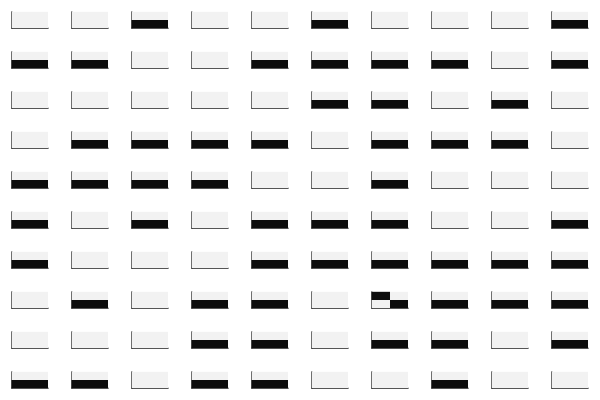

In [1]:
using Plots
using Yao, FLOYao
using LinearAlgebra
using JLD2
using BitBasis 

n = 2
nq = n^2

function create_circuit(nq::Int)
    layers = 20 #Number of brick-wall layers in the circuit
    g = chain(nq)
    for _ in 1:layers
        for i in 1:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Nearest-neighbor XX rotation gates
        end
        for i in 2:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => Y), 0.)) #Nearest-neighbor XY rotation gates
        end
        for i in 1:nq
            push!(g, put(nq, i => Rz(0.))) #Single qubit Z rotation gates
        end
    end
    return g
end

g = create_circuit(nq)
p = JLD2.load("gparams.jld2")["gparams"]
dispatch!(g, p)

function d_postprocess(measurement::Vector)
    l = length(measurement)
    aa = breflect.(measurement)
    ret = Matrix(undef, nq, l)
    for i in 1:l
        ret[:,i] = [aa[i]...]
    end
    return ret
end

#Testing the Generator
function sample(reg, theta, nbatch)
    nq = nqubits(reg)
    g = create_circuit(nq)
    dispatch!(g, theta)
    measurements = measure(apply(reg, g), nshots = nbatch)
    return d_postprocess(measurements)
end

nsamples = 100
samples = sample(FLOYao.zero_state(nq), parameters(g), nsamples)
Plots.plot([heatmap(reshape(samples[:,i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

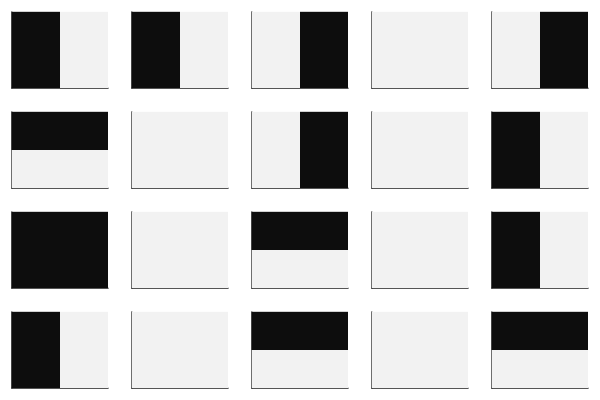

In [13]:
using Random
using Plots
using JLD2

n = 2
train = 20
display = JLD2.load("dataset.jld2")["data_train"]

Plots.plot([heatmap(reshape(x, n, n), color=:grays, colorbar = false, ticks = false) for x in display[1:train]]...)